In [45]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.tail())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s (mapped from %s)' % (np.unique(y), np.unique(df['Class label'])))

,Sepal length,Sepal width,Petal length,Petal width,Class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


#Training data points: 100
#Testing data points: 50
Class labels: [0 1 2] (mapped from ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'])


In [46]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train) # calculate the mean μ and variance  σ2 using only the training set
X_test_std = sc.transform(X_test)

In [47]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=60, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=60, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [48]:
from sklearn.metrics import accuracy_score

y_pred = ppn.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Misclassified samples: 9
Accuracy: 0.82


In [49]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

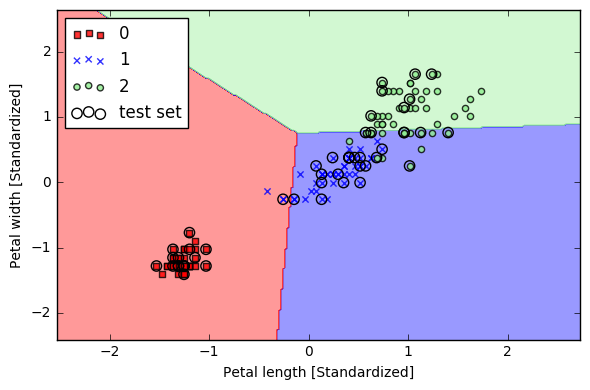

In [50]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('./output/fig-perceptron-scikit.png', dpi=300)
plt.show()

In [51]:
import numpy as np

class Perceptron2(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Number of epoches, i.e., passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    random_state : int
        The seed of the pseudo random number generator.

    """
    def __init__(self, eta=0.01, n_iter=10, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

#Training data points: 90
#Testing data points: 10
Class labels: [-1  1]


Misclassified samples: 3
Accuracy: 0.70


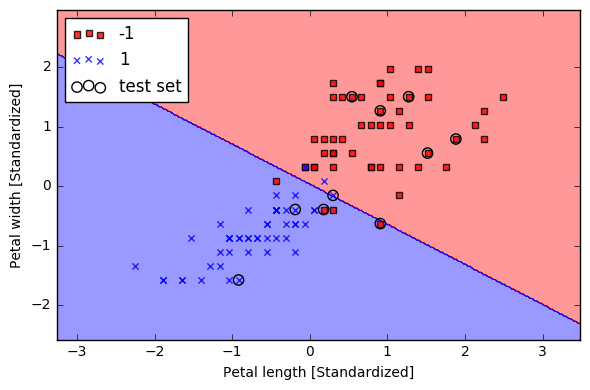

In [53]:
# training

ppn2 = Perceptron2(eta=0.1, n_iter=20)

ppn2.fit(X_train_std, y_train)

# testing

y_pred = ppn2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot descision boundary

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, 
                      classifier=ppn2, test_idx=range(len(y_train),
                                                      len(y_train) + len(y_test)))
plt.xlabel('Petal length [Standardized]')
plt.ylabel('Petal width [Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-perceptron2-boundary.png', dpi=300)
plt.show()

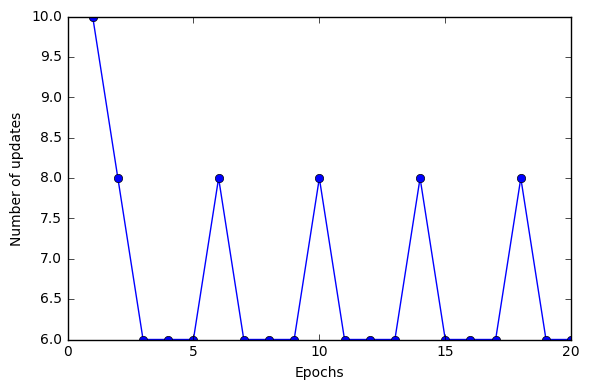

In [54]:
plt.plot(range(1, len(ppn2.errors_) + 1), ppn2.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

plt.tight_layout()
plt.savefig('./output/fig-perceptron2_errors.png', dpi=300)
plt.show()